In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

c:\Users\ioci\.conda\envs\torch_dip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [5]:
import os
from typing import Tuple
import torchaudio
from torch.utils.data import Dataset
from torch import Tensor
from pathlib import Path

def load_audio_item(filepath: str, path: str, label_name: str) -> Tuple[Tensor, int, str, str]:
    relpath = os.path.relpath(filepath, path)
    label, filename = os.path.split(relpath)
    if label_name is not None:
        label = label_name
    waveform, sample_rate = torchaudio.load(filepath, normalize = True, channels_first = True)
    return waveform, sample_rate, label, filename

class AudioFolder(Dataset):
    """Create a Dataset from Local Files.
    Args:
        path (str): Path to the directory where the dataset is found or downloaded.
        suffix (str) : Audio file type, defaulted to ".WAV".
        pattern (str) : Find pathnames matching this pattern. Defaulted to "*/*" 
        new_sample_rate (int) : Resample audio to new sample rate specified.
        spectrogram_transform (bool): If `True` transform the audio waveform and returns it  
        transformed into a spectrogram tensor.
        label (str): The label is pulled from the folders in the path, this allows you to statically
        define the label string.
    """


    def __init__(
            self,
            path: str,
            suffix: str = ".wav",
            pattern: str = "*/*",
            new_sample_rate: int = None,
            spectrogram_transform: bool = False,
            label: str = None
                    ):

        self._path = path
        self._spectrogram_transform = spectrogram_transform
        self._new_sample_rate = new_sample_rate
        self._label = label

        walker = sorted(str(p) for p in Path(self._path).glob(f'{pattern}{suffix}'))
        self._walker = list(walker)

    def __getitem__(self, n: int) -> Tuple[Tensor, int, Tensor, str, str]:
        """Load the n-th sample from the dataset.
        Args:
            n (int): The index of the file to be loaded
        Returns:
            tuple: ``(waveform, sample_rate, label, filename)``
        """
        fileid = self._walker[n]

        waveform, sample_rate, label, filename =  load_audio_item(fileid, self._path, self._label)
        spectrogram = None

        if self._new_sample_rate is not None:
            waveform = torchaudio.transforms.Resample(sample_rate, self._new_sample_rate)(waveform)
            sample_rate = self._new_sample_rate
        if self._spectrogram_transform is True:
            # waveform = torchaudio.transforms.MelSpectrogram()(waveform)
            # waveform = torch.flatten(torchaudio.transforms.Spectrogram()(waveform), start_dim=0, end_dim=1) 
            spectrogram = torchaudio.transforms.Spectrogram(n_fft = 1024)(waveform)

        return waveform, sample_rate, spectrogram, label, filename
    

    def __len__(self) -> int:
        return len(self._walker)

In [6]:
db = AudioFolder(path='./records_by_classes/', spectrogram_transform=True)

In [7]:
train_set, test_set = torch.utils.data.random_split(db, [0.7, 0.3])

In [8]:
waveform, sample_rate, spectrogram, label, file_name = train_set[0]
spectrogram.shape

torch.Size([1, 513, 469])

In [9]:
# transform = torchaudio.transforms.MelSpectrogram(sample_rate)
# mel_specgram = transform(spectrogram)
# mel_specgram.shape

In [10]:
label = sorted(list(set(datapoint[3] for datapoint in train_set)))
label

['bad', 'good', 'neutral']

To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(label.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return label[index]

In [12]:
def collate_fn(batch):
    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_set, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=collate_fn,
    batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_set, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=collate_fn,
    batch_size=batch_size)


## Training and Testing

In [13]:
from torchvision import models

model_ = models.mobilenet_v3_small(pretrained=True)

w = model_.features[0][0].weight
model_.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model_.features[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))

model_.classifier[3] = torch.nn.Linear(1024, len(label)) 
model_.to(device)

c:\Users\ioci\.conda\envs\torch_dip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ioci\.conda\envs\torch_dip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [14]:
# log_interval = 20
# n_epoch = 30

# pbar_update = 1 / (len(train_loader) + len(test_loader))
# losses = []
# accuracies = []

# optimizer = optim.Adam(model_.parameters(), lr=0.000025, weight_decay=0.0001)
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.8) 

# with tqdm(total=n_epoch, 
#           bar_format = "{desc}: {percentage:.2f}%|{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}]",
#           colour = 'GREEN',
#           ) as pbar:
#     for epoch in range(1, n_epoch + 1):
#         train(model_, epoch, log_interval)
#         accuracy_step = test(model_, epoch)
#         accuracies.append(accuracy_step)
#         scheduler.step()

In [15]:
# plt.plot(accuracies)
# plt.ylim(0, 100)
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.title("training accuracy")

In [16]:
# print(count_parameters(model_))

In [17]:
target_classes = {0:"bad", 1:"neutral", 2:"good"}
import numpy as np

def print_results(Y_actual, Y_preds, target_names):
    from sklearn.metrics import confusion_matrix, classification_report
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    
    tcs = ["bad", "good", "neutral"]
    print(classification_report(Y_actual, Y_preds, target_names=tcs))
    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def make_predictions(model, test_loader = test_loader):
    Y_shuffled, Y_preds = [], []

    model.eval()
    correct = 0

    with torch.no_grad():
       for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
  
        predicted_label = model(data)
        
        Y_preds.append(predicted_label)
        Y_shuffled.append(target)
            
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)
    
    a = F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

    return Y_shuffled.detach().cpu().numpy(), a


# Y_actual, Y_preds = make_predictions(model_)
# print(Y_actual)
# print(Y_preds)
# print_results(Y_actual, Y_preds, target_classes)

In [18]:
def save_model(model, path, name):
    model_scripted = torch.jit.script(model)
    model_scripted.save(path + name)

# save_model(model_, './audio/', 'audio_spectrogram_clsf_70.pt')

In [19]:
model_spectrogram = torch.load('./audio/audio_spectrogram_clsf_80.pt')
model_spectrogram.eval()

model_waveform = torch.load('./audio/audio_waveform_clsf_75bg.pt')
model_waveform.eval()

c:\Users\ioci\.conda\envs\torch_dip\lib\site-packages\torch\serialization.py:995: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=M5
  (conv1): RecursiveScriptModule(original_name=Conv1d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm1d)
  (pool1): RecursiveScriptModule(original_name=MaxPool1d)
  (conv2): RecursiveScriptModule(original_name=Conv1d)
  (bn2): RecursiveScriptModule(original_name=BatchNorm1d)
  (pool2): RecursiveScriptModule(original_name=MaxPool1d)
  (conv3): RecursiveScriptModule(original_name=Conv1d)
  (bn3): RecursiveScriptModule(original_name=BatchNorm1d)
  (pool3): RecursiveScriptModule(original_name=MaxPool1d)
  (conv4): RecursiveScriptModule(original_name=Conv1d)
  (bn4): RecursiveScriptModule(original_name=BatchNorm1d)
  (pool4): RecursiveScriptModule(original_name=MaxPool1d)
  (fc1): RecursiveScriptModule(original_name=Linear)
)

In [20]:
tc = {0:"bad", 1:"good", 2:"neutral"}
inverse_tc = {'bad':0, 'good':1, 'neutral':2}

from math import floor
def select_harder(a, b):
    inverse_translated_tc = {"bad":0, "neutral":1, "good":2}
    translated_tc = {0:'bad', 1:'neutral', 2:'good'}
    a_ = inverse_translated_tc[a]
    b_ = inverse_translated_tc[b]

    return inverse_tc[translated_tc[floor((a_ + b_) / 2)]]

def select_extreme(a, b):
    inverse_translated_tc = {"bad":0, "neutral":1, "good":2}
    translated_tc = {0:'bad', 1:'neutral', 2:'good'}
    a_ = inverse_translated_tc[a]
    b_ = inverse_translated_tc[b]
    t = (a_ + b_) / 2
    if t < 1:
        t = 0
    elif t > 1:
        t = 2
    else:
        t = 1
    res = translated_tc[t] 

    return inverse_tc[res]
    

dataloader = {'predict': torch.utils.data.DataLoader(db, batch_size = 1, shuffle=False)}
spec_res_list = []
wave_res_list = []
hard_list = []
extreme_list = []
Y_list = []
for waveform, freq, spectrogram, label, name in dataloader['predict']:
    output = model_spectrogram(spectrogram.to(device))
    output = output.to(device)
    spec_res = output.data.cpu().numpy().argmax()

    output_ = model_waveform(waveform.to(device))
    output_ = output_.to(device)
    wave_res = output_.data.cpu().numpy().argmax()

    hard = select_harder(tc[spec_res], tc[wave_res])
    extreme = select_extreme(tc[spec_res], tc[wave_res])

    print(f'{tc[extreme]:7} | {tc[hard]:7} | {tc[spec_res]:7} {tc[wave_res]:7} - {label[0]}')
    spec_res_list.append(spec_res)
    wave_res_list.append(wave_res)
    hard_list.append(hard)
    extreme_list.append(extreme)
    Y_list.append(inverse_tc[label[0]])

bad     | bad     | bad     bad     - bad
bad     | bad     | bad     bad     - bad
bad     | bad     | bad     bad     - bad
bad     | bad     | bad     bad     - bad
neutral | neutral | bad     good    - bad
bad     | bad     | bad     bad     - bad
neutral | neutral | bad     good    - bad
bad     | bad     | neutral bad     - bad
neutral | neutral | bad     good    - bad
bad     | bad     | neutral bad     - bad
bad     | bad     | neutral bad     - bad
bad     | bad     | neutral bad     - bad
bad     | bad     | bad     bad     - bad
bad     | bad     | neutral bad     - bad
neutral | neutral | neutral neutral - bad
neutral | neutral | neutral neutral - bad
bad     | bad     | bad     neutral - bad
neutral | neutral | neutral neutral - bad
neutral | neutral | neutral neutral - bad
neutral | neutral | neutral neutral - bad
bad     | bad     | neutral bad     - bad
bad     | bad     | neutral bad     - bad
bad     | bad     | bad     bad     - bad
bad     | bad     | bad     neutra

In [22]:
spec_res_list = []
wave_res_list = []
sum_res_list = []
Y_list = []
for waveform, freq, spectrogram, label, name in dataloader['predict']:
    output = model_spectrogram(spectrogram.to(device))
    output = output.to(device)
    spec_res = output.data.cpu() 
    spec_res = F.softmax(spec_res,dim=-1).numpy() #.argmax()

    output_ = model_waveform(waveform.to(device))
    output_ = output_.to(device)
    wave_res = output_.data.cpu()
    wave_res = F.softmax(wave_res,dim=-1).numpy() #.argmax()   

    sum_res = (spec_res + wave_res).argmax()  
    
    spec_res = spec_res.argmax()
    wave_res = wave_res.argmax()
    # print(f'[{spec_res[0][0]:5.2f} {spec_res[0][1]:5.2f} {spec_res[0][2]:5.2f}] [{wave_res[0][0][0]:5.2f} {wave_res[0][0][1]:5.2f} {wave_res[0][0][2]:5.2f}] | {tc[sum_res]} - {label[0]}')
    print(f'{tc[spec_res]:7} {tc[wave_res]:7} | {tc[sum_res]:7} - {label[0]}')
    spec_res_list.append(spec_res)
    wave_res_list.append(wave_res)
    sum_res_list.append(sum_res)

    Y_list.append(inverse_tc[label[0]])

bad     bad     | bad     - bad
bad     bad     | bad     - bad
bad     bad     | bad     - bad
bad     bad     | bad     - bad
bad     good    | bad     - bad
bad     bad     | bad     - bad
bad     good    | bad     - bad
neutral bad     | bad     - bad
bad     good    | bad     - bad
neutral bad     | bad     - bad
neutral bad     | neutral - bad
neutral bad     | neutral - bad
bad     bad     | bad     - bad
neutral bad     | neutral - bad
neutral neutral | neutral - bad
neutral neutral | neutral - bad
bad     neutral | bad     - bad
neutral neutral | neutral - bad
neutral neutral | neutral - bad
neutral neutral | neutral - bad
neutral bad     | neutral - bad
neutral bad     | neutral - bad
bad     bad     | bad     - bad
bad     neutral | neutral - bad
bad     bad     | bad     - bad
bad     bad     | bad     - bad
bad     bad     | bad     - bad
bad     bad     | bad     - bad
neutral good    | neutral - bad
bad     bad     | bad     - bad
bad     bad     | bad     - bad
bad     

              precision    recall  f1-score   support

         bad       0.91      0.62      0.74        32
        good       0.95      0.86      0.90        80
     neutral       0.60      0.89      0.71        35

    accuracy                           0.82       147
   macro avg       0.82      0.79      0.79       147
weighted avg       0.85      0.82      0.82       147



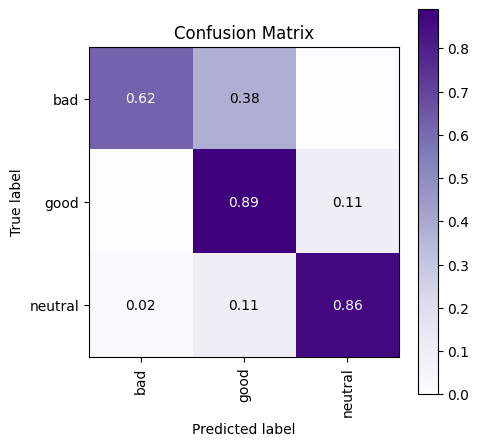

In [28]:
print_results(Y_list, sum_res_list, tc)